image_0151.jpg


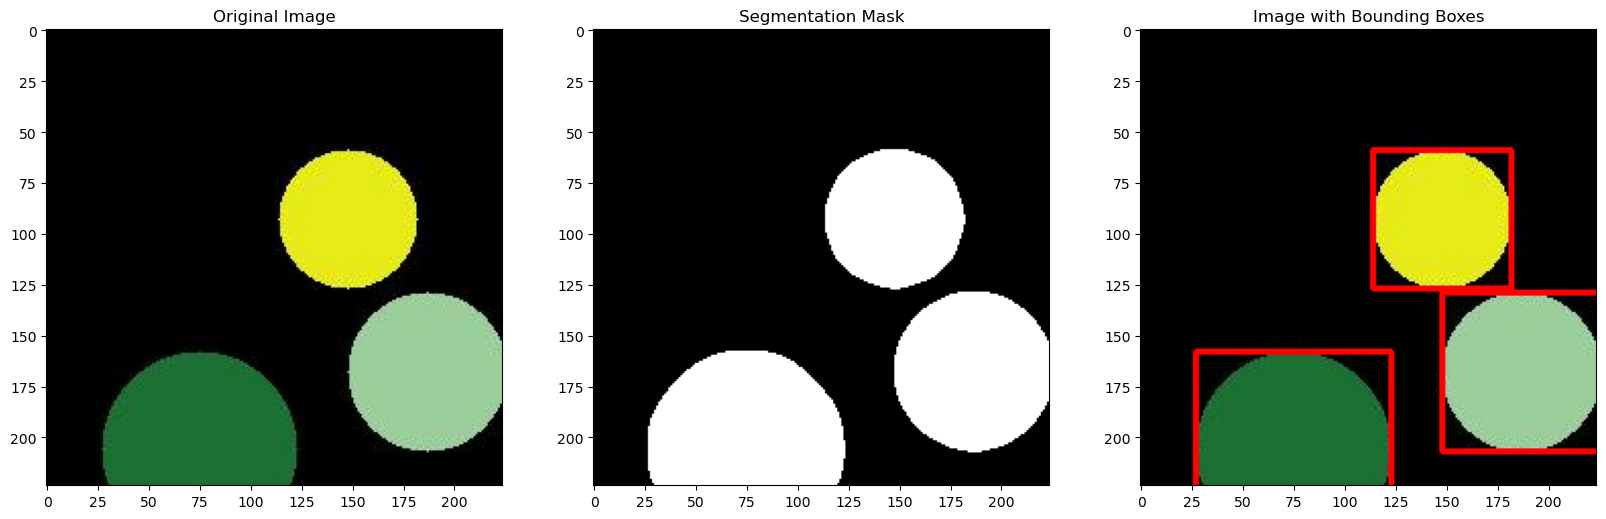

In [1]:
import cv2
import matplotlib.pyplot as plt
import json
import numpy as np

def load_annotations(json_file):
    """Load annotations from a JSON file."""
    with open(json_file, 'r') as f:
        data = json.load(f)
    return data

def create_mask(image_shape, annotations):
    """Create a mask from segmentation data."""
    mask = np.zeros(image_shape[:2], dtype=np.uint8)
    for annotation in annotations:
        segmentation = annotation['segmentation'][0]  # Assuming single segmentation per annotation
        segmentation = np.array(segmentation).reshape(-1, 2)
        pts = np.array([segmentation], dtype=np.int32)
        cv2.fillPoly(mask, pts, 255)
    return mask

def draw_bounding_boxes(image, annotations):
    """Draw bounding boxes on the image."""
    for annotation in annotations:
        bbox = annotation['bbox']
        x, y, w, h = bbox
        cv2.rectangle(image, (int(x), int(y)), (int(x + w), int(y + h)), (255, 0, 0), 2)
    return image

def view_image_mask_bboxes(image_path, annotations):
    """Load image and annotations, create mask, and display all side by side."""
    # Load image
    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB for matplotlib

    # Create mask from segmentation
    mask = create_mask(img.shape, annotations)
    
    # Draw bounding boxes on a copy of the image
    img_with_bboxes = img_rgb.copy()
    img_with_bboxes = draw_bounding_boxes(img_with_bboxes, annotations)
    
    # Plotting
    fig, axes = plt.subplots(1, 3, figsize=(20, 10))
    
    # Original Image
    axes[0].imshow(img_rgb)
    axes[0].set_title('Original Image')
    axes[0].axis('on')

    # Mask
    axes[1].imshow(mask, cmap='gray')
    axes[1].set_title('Segmentation Mask')
    axes[1].axis('on')

    # Image with Bounding Boxes
    axes[2].imshow(img_with_bboxes)
    axes[2].set_title('Image with Bounding Boxes')
    axes[2].axis('on')
    
    plt.show()

# Paths
annotations_file = '/home/localssk23/SOLOv2/datasets/dummy_2d/annotations.json'
image_dir = '/home/localssk23/SOLOv2/datasets/dummy_2d/imgs/'

# Load annotations
data = load_annotations(annotations_file)

# Example: View annotations for the first image
first_image_info = data['images'][151]
image_filename = first_image_info['file_name']
print(image_filename)
image_path = image_dir + image_filename

# Get annotations for the first image
image_id = first_image_info['id']
annotations = [ann for ann in data['annotations'] if ann['image_id'] == image_id]

# View the image, mask, and bounding boxes
view_image_mask_bboxes(image_path, annotations)

In [2]:
# Paths
annotations_file = '/home/localssk23/SOLOv2/data/casia-SPT_val/val/val_annotation.json'
image_dir = '/home/localssk23/SOLOv2/data/casia-SPT_val/val/'

# Load annotations
data = load_annotations(annotations_file)

# Example: View annotations for the first image
first_image_info = data['images'][100]
image_filename = first_image_info['file_name']
image_path = image_dir + image_filename

# Get annotations for the first image
image_id = first_image_info['id']
annotations = [ann for ann in data['annotations'] if ann['image_id'] == image_id]

# View the image, mask, and bounding boxes
view_image_mask_bboxes(image_path, annotations)

FileNotFoundError: [Errno 2] No such file or directory: '/home/localssk23/SOLOv2/data/casia-SPT_val/val/val_annotation.json'

Volume filename: volume_0000.npy
Number of annotations: 5
Volume shape: (64, 64, 64)


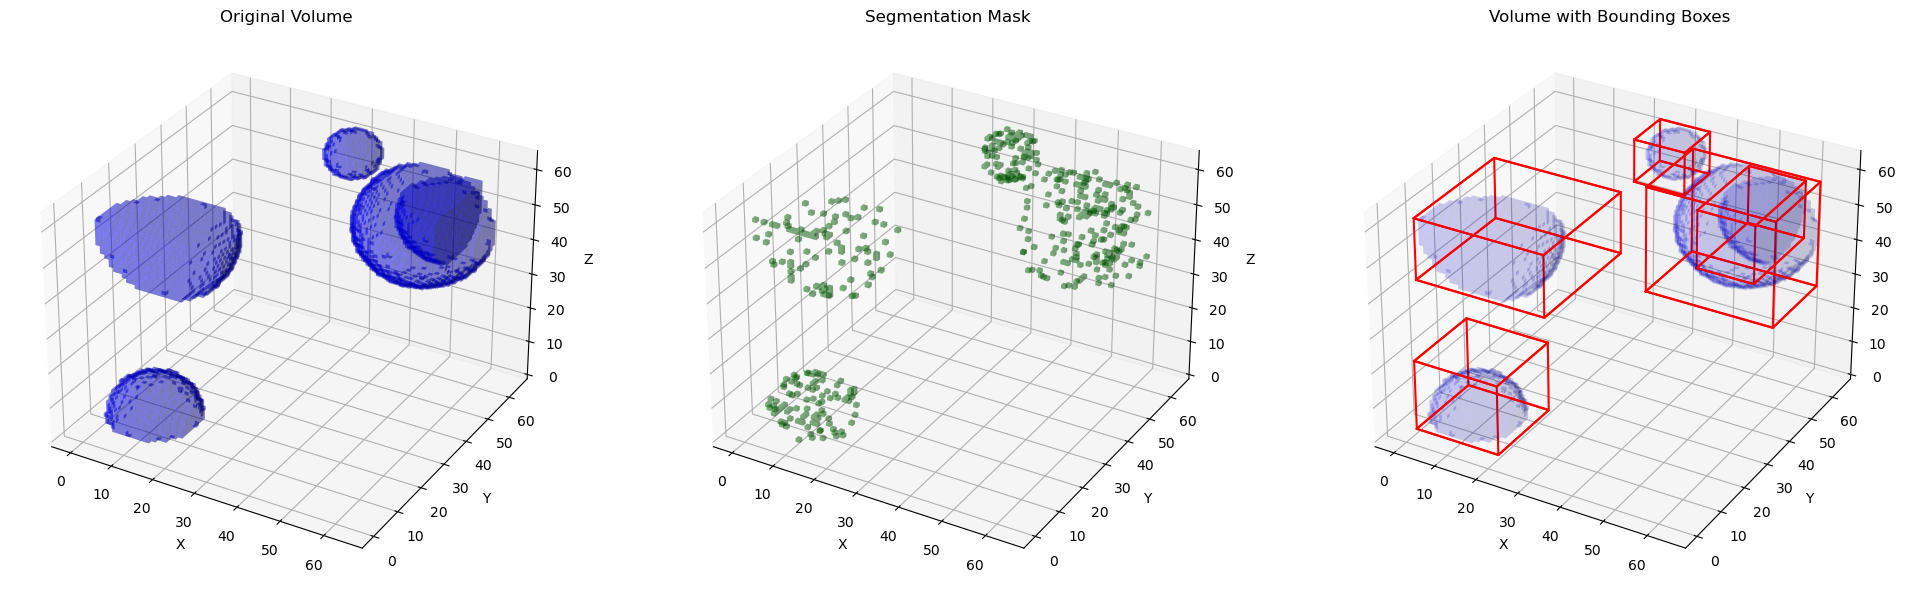

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import json
from mpl_toolkits.mplot3d import Axes3D

def load_annotations(json_file):
    """Load annotations from a JSON file."""
    with open(json_file, 'r') as f:
        data = json.load(f)
    return data

def create_3d_mask(volume_shape, annotations):
    """Create a 3D mask from segmentation data."""
    mask = np.zeros(volume_shape, dtype=np.uint8)
    for annotation in annotations:
        segmentation = np.array(annotation['segmentation'][0]).reshape(-1, 3)
        x, y, z = segmentation[:, 0], segmentation[:, 1], segmentation[:, 2]
        
        # Clamp coordinates to volume bounds
        x = np.clip(x, 0, volume_shape[0] - 1)
        y = np.clip(y, 0, volume_shape[1] - 1)
        z = np.clip(z, 0, volume_shape[2] - 1)
        
        mask[x.astype(int), y.astype(int), z.astype(int)] = 255
    return mask

def draw_bounding_boxes_3d(ax, annotations, volume_shape):
    """Draw 3D bounding boxes."""
    for annotation in annotations:
        bbox = annotation['bbox']
        x, y, z, w, h, d = bbox
        
        # Clamp coordinates to volume bounds
        x = max(0, min(x, volume_shape[0] - 1))
        y = max(0, min(y, volume_shape[1] - 1))
        z = max(0, min(z, volume_shape[2] - 1))
        w = min(w, volume_shape[0] - x)
        h = min(h, volume_shape[1] - y)
        d = min(d, volume_shape[2] - z)
        
        # Create wireframe for the bounding box
        xx, yy = np.meshgrid([x, x+w], [y, y+h])
        ax.plot_wireframe(xx, yy, z * np.ones_like(xx), color="r")
        ax.plot_wireframe(xx, yy, (z+d) * np.ones_like(xx), color="r")
        ax.plot([x, x, x+w, x+w, x], [y, y+h, y+h, y, y], [z, z, z, z, z], color="r")
        ax.plot([x, x, x+w, x+w, x], [y, y+h, y+h, y, y], [z+d, z+d, z+d, z+d, z+d], color="r")
        ax.plot([x, x], [y, y], [z, z+d], color="r")
        ax.plot([x, x], [y+h, y+h], [z, z+d], color="r")
        ax.plot([x+w, x+w], [y, y], [z, z+d], color="r")
        ax.plot([x+w, x+w], [y+h, y+h], [z, z+d], color="r")

def view_volume_mask_bboxes(volume_path, annotations):
    """Load volume and annotations, create mask, and display all side by side."""
    # Load volume
    volume = np.load(volume_path)
    print(f"Volume shape: {volume.shape}")
    
    # Create mask from segmentation
    mask = create_3d_mask(volume.shape, annotations)
    
    # Plotting
    fig = plt.figure(figsize=(20, 6))
    
    # Original Volume
    ax1 = fig.add_subplot(131, projection='3d')
    ax1.voxels(volume > 0, facecolors='blue', alpha=0.3)
    ax1.set_title('Original Volume')
    ax1.set_xlabel('X')
    ax1.set_ylabel('Y')
    ax1.set_zlabel('Z')

    # Mask
    ax2 = fig.add_subplot(132, projection='3d')
    ax2.voxels(mask > 0, facecolors='green', alpha=0.3)
    ax2.set_title('Segmentation Mask')
    ax2.set_xlabel('X')
    ax2.set_ylabel('Y')
    ax2.set_zlabel('Z')

    # Volume with Bounding Boxes
    ax3 = fig.add_subplot(133, projection='3d')
    ax3.voxels(volume > 0, facecolors='blue', alpha=0.1)
    draw_bounding_boxes_3d(ax3, annotations, volume.shape)
    ax3.set_title('Volume with Bounding Boxes')
    ax3.set_xlabel('X')
    ax3.set_ylabel('Y')
    ax3.set_zlabel('Z')
    
    plt.tight_layout()
    plt.show()

# Paths
annotations_file = '/home/localssk23/SOLOv2/dummy_data/dataset/annotations_3d.json'
volume_dir = '/home/localssk23/SOLOv2/dummy_data/dataset/volumes/'

# Load annotations
data = load_annotations(annotations_file)

# Example: View annotations for the first volume
first_volume_info = data['volumes'][0]
volume_filename = first_volume_info['file_name']
print(f"Volume filename: {volume_filename}")
volume_path = volume_dir + volume_filename

# Get annotations for the first volume
volume_id = first_volume_info['id']
annotations = [ann for ann in data['annotations'] if ann['volume_id'] == volume_id]
print(f"Number of annotations: {len(annotations)}")

# View the volume, mask, and bounding boxes
view_volume_mask_bboxes(volume_path, annotations)